***
### <font color=red>Chapter 5: MedTALN inc.'s Case Study - Dataset preparation for Labeling</font>
<p style="margin-left:10%; margin-right:10%;">by <font color=teal> John Doe (typica.ai) </font></p>

***


#### Overview:
This notebook prepares a dataset for the OCI Data Labeling Service. It involves several key processes including data download, cleaning, balancing, and final transformation into Jsonl Consolidated format, suitable for labeling tasks.

# 1. Data Access:
- **Purpose:** Retrieve the dataset for use in this notebook.
- **Method:** Download the selected dataset directly into the notebook environment.

Hugging face datasets library is already included in our installed conda env. (i.e. pytorch21_p39_gpu_v1).
in case you want to reinstall it use: !pip install datasets==2.16.1

Filters out warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

Use the load_dataset() function to load the dataset from Hugging Face Hub repository by providing the dataset namespace and name i.e. TypicaAI/pii-masking-60k_fr.


In [3]:
from datasets import load_dataset
orig_dataset = load_dataset("TypicaAI/MedicalNER_Fr")
orig_dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sample_id', 'tokens', 'ner_tags', 'text', 'ner_tags_span'],
        num_rows: 16176
    })
})

Strip all the columns from the downloaded dataset except columns text ner_tags_span

In [4]:
from datasets import Dataset, DatasetDict

# Assuming cleaned_dataset['train'] is a dataset object
# Select only the desired columns
streamlined_dataset = orig_dataset['train'].remove_columns([col for col in orig_dataset['train'].column_names if col not in ['text', 'ner_tags_span']])

# Create a new dataset with only these columns
streamlined_dataset = DatasetDict({
    'train': streamlined_dataset
})

# Print the columns to verify
streamlined_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'ner_tags_span'],
        num_rows: 16176
    })
})

In [5]:
streamlined_dataset['train'][0]

{'text': 'atteint de poliomyélite dans son enfance il devient fan de blues en écoutant big joe turner .',
 'ner_tags_span': "[['Disease', 11, 23], ['PER', 77, 91]]"}

# 2. Dataset Wrangling:
This phase ensures the dataset is ready for labeling, involving two main tasks:cleaning and balancing the dataset

### 2a. Cleaning:

This function is useful for standardizing NER labels in a dataset by consolidating certain non medical entities types under a single label, 'MISC'.

In [6]:
import ast  # Import abstract syntax trees module to safely parse strings into lists

# Define the labels that need to be renamed to 'MISC'
labels_to_map = {'LOC', 'PER', 'PROD', 'CW', 'ORG', 'GRP'}

def rename_labels_to_misc(example):
    # Convert the string representation of list into an actual list
    ner_tags_span = ast.literal_eval(example['ner_tags_span'])

    # Rename labels to 'MISC'
    renamed_ner_tags_span = [
        ['MISC', start, end] if label in labels_to_map else [label, start, end]
        for label, start, end in ner_tags_span
    ]

    # Update the example with the renamed labels
    example['ner_tags_span'] = str(renamed_ner_tags_span)

    return example

The Hugging Face `datasets` library `map` function apply `rename_labels_to_misc` across the dataset.

In [7]:
# Apply the function across the dataset using map
cleaned_dataset = streamlined_dataset.map(rename_labels_to_misc, batched=False)
cleaned_dataset

Map:   0%|          | 0/16176 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'ner_tags_span'],
        num_rows: 16176
    })
})

The Hugging Face `datasets` library `filter` is used to remove example wiht text length inf. to 50 characters

In [8]:
# Define the minimum text length (e.g., 10 characters)
min_text_length = 50
# remove examples with text lenght < min_text_length
filtered_dataset = cleaned_dataset.filter(lambda example: len(example['text']) >= min_text_length)

orig_ds_count = len(orig_dataset['train'])
filtered_ds_count = len(filtered_dataset['train'])

print(f"Original number of examples: {orig_ds_count}")
print(f"Number of examples (after filtering): {filtered_ds_count}")

Filter:   0%|          | 0/16176 [00:00<?, ? examples/s]

Original number of examples: 16176
Number of examples (after filtering): 14722


In [9]:
filtered_dataset["train"][0]

{'text': 'atteint de poliomyélite dans son enfance il devient fan de blues en écoutant big joe turner .',
 'ner_tags_span': "[['Disease', 11, 23], ['MISC', 77, 91]]"}

The script plots the dataset size before and after the cleaning.

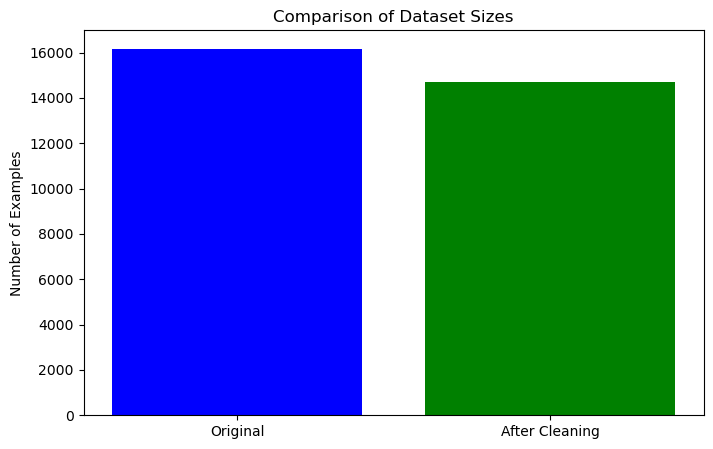

In [9]:
import matplotlib.pyplot as plt

# Data setup
categories = ['Original', 'After Cleaning']
values = [orig_ds_count, filtered_ds_count]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(categories, values, color=['blue', 'green'])
plt.title('Comparison of Dataset Sizes')
plt.ylabel('Number of Examples')
plt.show()

### 2b. Balancing:

Adjust the dataset to ensure all entities are equally represented, using undersampling techniques as necessary.

In [10]:
from collections import Counter
import ast

def extract_labels(ner_tags_span):
    """Helper function to parse and filter labels from ner_tags_span."""
    return [label[0] for label in ast.literal_eval(ner_tags_span)]

def count_labels(dataset):
    """Counts occurrences of each label in the dataset's ner_tags_span field, excluding 'O'."""

    # Use a list comprehension to gather all labels across the dataset and count them
    label_counts = Counter(
        label for example in dataset['train']
        for label in extract_labels(example['ner_tags_span'])
    )
    return label_counts

Define `plot_distributions` function. This function is designed to visually compare the distributions of a dataset's labels before and after the balancing step. It uses the matplotlib library to create a bar chart, which displays the counts of each label side-by-side for easy comparison. 

In [11]:
def plot_distributions(before_counts, after_counts, process="Balancing"):
    # Sort labels to ensure they match up in the plot
    labels = sorted(before_counts.keys())
    before_values = [before_counts[label] for label in labels]
    after_values = None
    if after_counts:
      after_values = [after_counts[label] for label in labels]

    x = range(len(labels))  # Label location on x-axis

    # Create the bar plot
    plt.figure(figsize=(10, 5))
    plt.bar(x, before_values, width=0.4, label=f'Before {process}', color='b', align='center')
    if after_values:
      plt.bar(x, after_values, width=0.4, label=f'After {process}', color='r', align='edge')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(f'Label Distribution Before and After {process}')
    plt.xticks(x, labels, rotation='vertical')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

Calculates and prints the label distribution to assess the dataset initial balance.

In [12]:
# count labels for the cleaned dataset
label_counts = count_labels(filtered_dataset)
print("Label Counts:", label_counts)

Label Counts: Counter({'Disease': 4291, 'AnatomicalStructure': 4246, 'Medication/Vaccine': 3952, 'MedicalProcedure': 2930, 'Symptom': 1577, 'MISC': 1550})


Plot the label distribution before balancing.

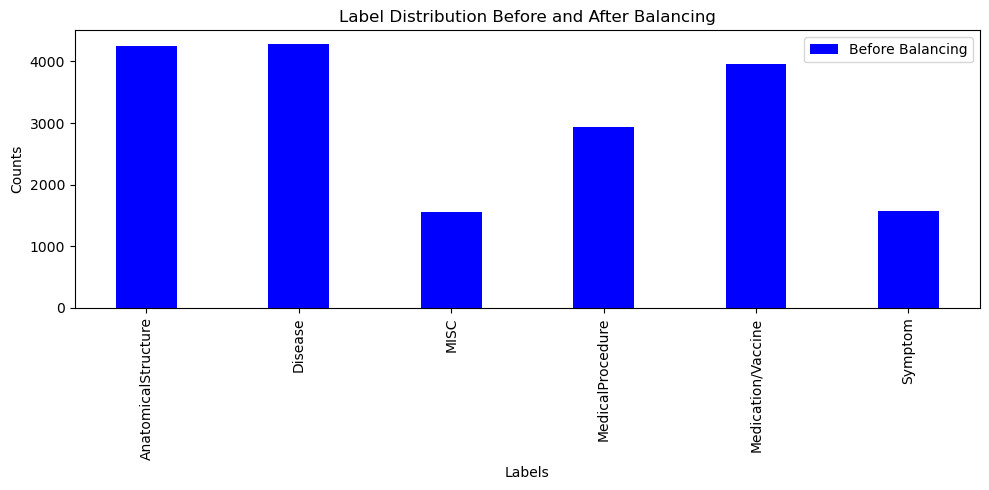

In [13]:
plot_distributions(label_counts, None)  # Plot the label counts

We notice that the dataset's classes are imbalanced

The `undersample_label` function applies the "Random Under-Sampling" approach to adjust the frequency of a specified label within a dataset to prevent overrepresentation.

In [14]:
import random
from datasets import Dataset, DatasetDict

def extract_labels(ner_tags_span):
    """
    Extracts the labels from the ner_tags_span field.
    Assumes ner_tags_span is a string representation of a list of [label, start, end] triplets.
    """
    tags = ast.literal_eval(ner_tags_span)
    labels = [tag[0] for tag in tags if tag[0] != 'O']
    return labels

def undersample_label(dataset, label_to_undersample, target_count, seed):
    """Reduces the occurrences of a specified label to a target count."""
    examples_with_label = [ex for ex in dataset if label_to_undersample in extract_labels(ex['ner_tags_span'])]
    examples_without_label = [ex for ex in dataset if label_to_undersample not in extract_labels(ex['ner_tags_span'])]

    random.seed(seed)  # Set the random seed for reproducibility

    if len(examples_with_label) > target_count:
        examples_with_label = random.sample(examples_with_label, target_count)

    new_dataset = examples_with_label + examples_without_label
    return new_dataset


# The target count based on the 'Symptom' label
target_count = 2000

# Start with the filtered dataset
balanced_ds_list = filtered_dataset['train']

# Loop over labels with count > 2000 and apply undersampling
for label, count in label_counts.items():
    if count > target_count:
        print(f"Undersampling label '{label}' from {count} to {target_count}")
        balanced_ds_list = undersample_label(balanced_ds_list, label, target_count, seed=42)

# Convert the balanced dataset to a Hugging Face dataset
balanced_dataset = DatasetDict({
    'train': Dataset.from_dict({
        'text': [ex['text'] for ex in balanced_ds_list],
        'ner_tags_span': [ex['ner_tags_span'] for ex in balanced_ds_list]
    })
})

print("Balancing complete. Dataset ready for training.")


Undersampling label 'Disease' from 4291 to 2000
Undersampling label 'AnatomicalStructure' from 4246 to 2000
Undersampling label 'Medication/Vaccine' from 3952 to 2000
Undersampling label 'MedicalProcedure' from 2930 to 2000
Balancing complete. Dataset ready for training.


After undersampling is applyied to labels with count > 2000, a new balanced dataset is created

Recount and plot the label distribution after balancing

In [15]:
# Recalculate the new label counts
new_label_counts = count_labels(balanced_dataset)
print("Label Counts:", new_label_counts)

Label Counts: Counter({'Medication/Vaccine': 2312, 'AnatomicalStructure': 2236, 'MedicalProcedure': 2135, 'Disease': 2079, 'Symptom': 1465, 'MISC': 975})


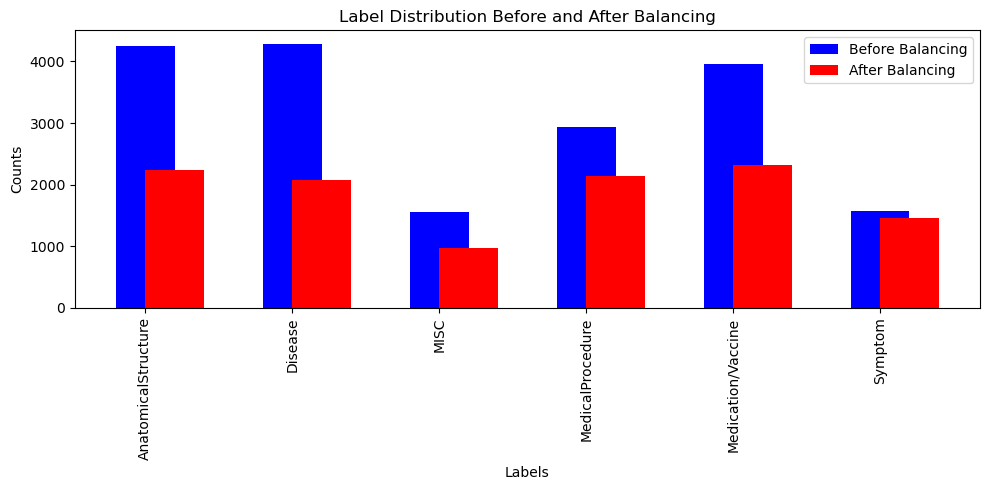

In [16]:
# plot the new label distribution
plot_distributions(label_counts, new_label_counts)  # Plot the label new counts

### 2c. Transforming:

- **Objective**: Convert the balanced dataset to an OCI Data Labeling dataset (Jsonl Consolidated format).
- **Process**: Reformat the data into the required Jsonl Consolidated structure and save it to the OCI Labeling Datasets Bucket for further use.

Now that we have balanced our dataset, let's transform it into a suitable format for OCI Data Labeling `Jsonl Consolidated` and save it to our Labeling Datasets Bucket.

The code snippet, based on our balanced dataset, creates in our *Labeling Datasets Bucket* the files for our future OCI Data Labeling Dataset to be imported:
- Metadata file (JSONL Consolidated format), which includes the new dataset details and annotations for each example.
- Record files, which are text files where each one represents one example from the balanced dataset.

**Tip:** The default service limit for DLS record count is 10,000. If we want to avoid the record-count limit issue, we need to reduce the size of our balanced dataset. In a real-world situation, if the number of records we need to create exceeds the number of available records, you must file a regular Customer Account Management (CAM) ticket to request an increase in the limit.

In [19]:
len(balanced_dataset["train"])

9052

Downsize the dataset to 9,000 examples by randomly selecting a subset of 9,000 examples

In [20]:
from datasets import DatasetDict

# Set the seed for reproducibility
seed = 42
new_size= 9000

# Shuffle the train dataset using the specified seed
shuffled_train_dataset = balanced_dataset["train"].shuffle(seed=seed)

# Select the first 3000 examples from the shuffled train dataset
healthcare_ner_dataset_v1 = shuffled_train_dataset.select(range(new_size))

# Convert the sampled dataset back to a DatasetDict if needed
healthcare_ner_dataset_v1 = DatasetDict({
    "train": healthcare_ner_dataset_v1
})
healthcare_ner_dataset_v1

DatasetDict({
    train: Dataset({
        features: ['text', 'ner_tags_span'],
        num_rows: 9000
    })
})

Revalidate the label distribution after the downsizing of the balanced dataset

In [21]:
# Recalculate the new label counts
healthcare_ner_dataset_v1_label_counts = count_labels(healthcare_ner_dataset_v1)
print("Label Counts:", healthcare_ner_dataset_v1_label_counts)

Label Counts: Counter({'Medication/Vaccine': 2298, 'AnatomicalStructure': 2219, 'MedicalProcedure': 2122, 'Disease': 2069, 'Symptom': 1459, 'MISC': 969})


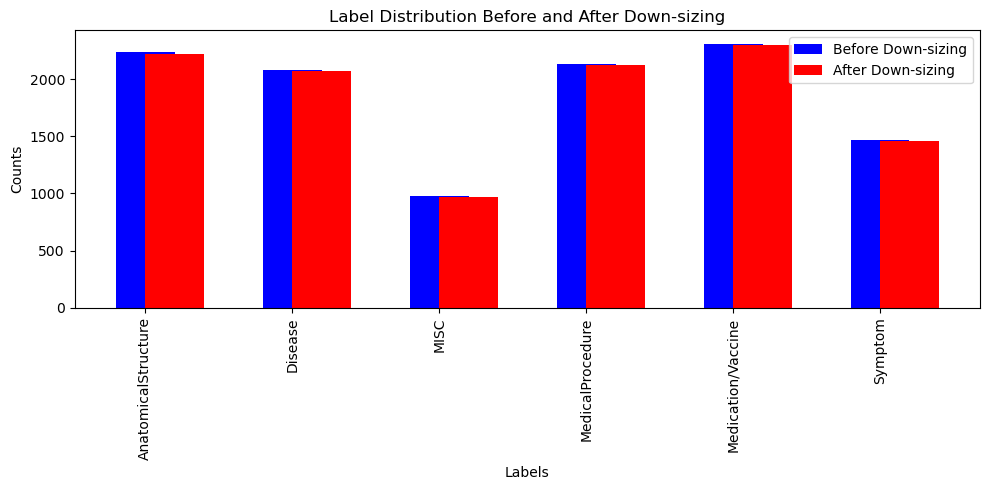

In [22]:
# Plot the balanced label count vs. downsized label counts
plot_distributions(new_label_counts, healthcare_ner_dataset_v1_label_counts, "Down-sizing")

The downsized dataset is balanced enough for our case study.

At this stage, we can save the downsized dataset to the `training-datasets-bkt` as a restore point for this dataset or for later use (if needed).

In [23]:
healthcare_ner_dataset_v1.save_to_disk('/home/datascience/buckets/training-datasets-bkt/healthcare_ner_dataset_v1.0.0')

Saving the dataset (0/1 shards):   0%|          | 0/9000 [00:00<?, ? examples/s]

Let's create the OCI Data Labeling dataset in Jsonl Consolidated format.

In [24]:
import oci
from datasets import load_dataset
import json
import io
import os
import tempfile
from tqdm import tqdm

# Initialize OCI Object Storage Client with notebook session's resource principal
signer = oci.auth.signers.get_resource_principals_signer()
object_storage_client = oci.object_storage.ObjectStorageClient(config={}, signer=signer)

#set dataset display name
dataset_display_name = "healthcare_ner_dataset_v1.0.0" 
dataset_description = "Healthcare NER Dataset for the Case Study",

# Initialize Object Storage bucket infos
namespace = object_storage_client.get_namespace().data
bucket_name = "labelling-datasets-bkt"

# Base folder in the bucket
base_folder = f"{dataset_display_name}/" 

labels_set = set()
annotations_list = []

for idx, item in enumerate(tqdm(healthcare_ner_dataset_v1["train"], 
                                desc="processing dataset records", 
                                total=len(healthcare_ner_dataset_v1["train"])
                               )
                          ):
    
    text = item['text']
    ner_tags_span = eval(item['ner_tags_span'])  # Convert string to list if necessary

    # Prepare annotations for this row
    entities = []
    for label,start, end in ner_tags_span:
        label = label.replace("/","")
        labels_set.add(label)  # Add to the set of unique labels
        entities.append({
            "entityType": "TEXTSELECTION",
            "labels": [{"label_name": label}],
            "textSpan": {"offset": start, "length": end - start}
        })

    if len(entities) > 0:
        file_name = f"rec-{idx}.txt"
        annotations_list.append({
            "sourceDetails": {"path": file_name},
            "annotations": [{"entities": entities}]
        })

        # Upload the text to OCI bucket
        record_filename = f"{base_folder}{file_name}"
        record_body = io.BytesIO(text.encode('utf-8'))
        
        #with open(temp_file_path, 'rb') as f:
        object_storage_client.put_object(namespace,
                                         bucket_name,
                                         record_filename,
                                         record_body, #f, #
                                         content_type='text/plain'
                                        )
        
# Prepare the dataset metadata, i.e., JSONL Metadata
dataset_details = {
    "displayName": dataset_display_name, # "Healthcare NER Dataset v1.0.0",
    "description": "Healthcare NER Case Study - Dataset ready for adding annotations using OCI Data Labeling Service.",
    "labelsSet": [{"name": label} for label in labels_set],
    "annotationFormat": "ENTITY_EXTRACTION",
    "datasetFormatDetails": {"formatType": "TEXT"}
}

# Metadata and annotations as JSONL string
jsonl_data = json.dumps(dataset_details) + '\n' + '\n'.join(json.dumps(annotation) for annotation in annotations_list)

# Write the metadata and annotations to a JSONL file
jsonl_data = io.BytesIO(jsonl_data.encode('utf-8'))

#with open(temp_file_path, 'rb') as f:
object_storage_client.put_object(namespace,
                                 bucket_name,
                                 f"{base_folder}dataset_metadata.jsonl",
                                 jsonl_data, #f, #
                                 content_type='application/json')
        
print(f'The Dataset {dataset_details["displayName"]} was created successfully in the bucket {bucket_name}')

processing dataset records: 100%|██████████| 9000/9000 [05:34<00:00, 26.91it/s]


The Dataset healthcare_ner_dataset_v1.0.0 was created successfully in the bucket labelling-datasets-bkt
